In [2]:
import numpy as np
from matplotlib import pyplot as plt
import PIL


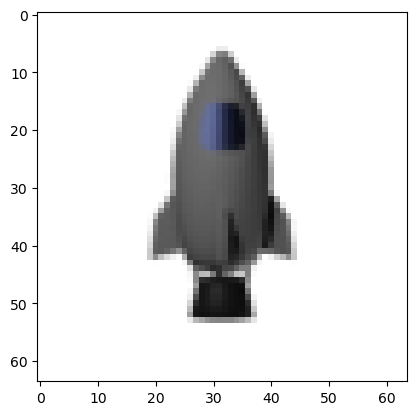

In [3]:
srgb = plt.imread('../models/sprites.png')[:64, 64:128]


image = srgb

fig = plt.figure(frameon=False)
plt.imshow(image)
# im2 = plt.imshow(Z, cmap=plt.cm.viridis, alpha=.9, interpolation='bilinear')

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


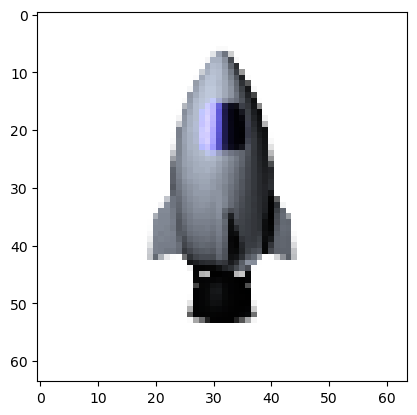

In [4]:
linear = np.power(image, 2.2)
toXYZ = np.array([
  [0.4124, 0.3576, 0.1805, 0],
  [0.2126, 0.7152, 0.0722, 0],
  [0.0193, 0.1192, 0.9505, 0],
  [0, 0, 0, 1],
  ])
xyz = np.einsum('ab,cdb->cda', toXYZ, linear)

plt.imshow(xyz*5)


0.45454545454545453


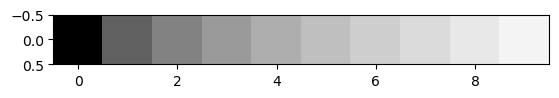

In [5]:
linear = np.einsum('cab->cba', [[np.arange(0,1,0.1), np.arange(0,1,0.1), np.arange(0,1,0.1)]])
plt.imshow(linear)
plt.imshow(np.power(linear, 1/2.4))
print(1/2.2)


1.4492722509830631 1.417453055115626 1.7820755249659754


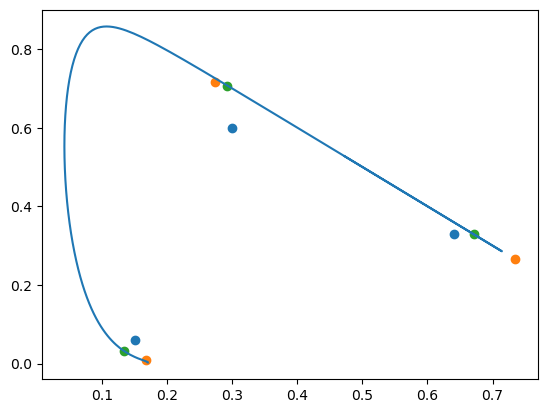

In [6]:
# Simple Analytic Approximations to the CIE XYZ Color Matching Functions
# https://jcgt.org/published/0002/02/01/
x = lambda l: 1.065 * np.exp(-1/2 * np.square((l - 595.8) / 33.33)) + 0.366 * np.exp(-1/2 * np.square((l - 446.8) / 19.44))
y = lambda l: 1.014 * np.exp(-1/2 * np.square((np.log(l) - np.log(556.3)) / 0.075))
z = lambda l: 1.839 * np.exp(-1/2 * np.square((np.log(l) - np.log(449.8)) / 0.051))
xyz = lambda l: x(l) + y(l) + z(l)
xy = lambda l: (x(l) / xyz(l), y(l) / xyz(l))

# spectral root color frequencies
# chosen to roughly contain the whole sRGB space quite tightly
R, G, B = 610, 550, 465
xyzToSpectral = np.linalg.inv(np.array([
  [x(R), x(G), x(B)],
  [y(R), y(G), y(B)],
  [z(R), z(G), z(B)],
]))

plt.plot(*zip(*[xy(i) for i in np.arange(436, 700)]))
plt.scatter([0.64, 0.30, 0.15], [0.33, 0.60, 0.06])       # sRGB
plt.scatter([0.735, 0.274, 0.167], [0.265, 0.717, 0.009]) # CIE RGB
plt.scatter(*zip(xy(R), xy(G), xy(B))) # spectral RGB
print(xyz(R), xyz(G), xyz(B))


In [16]:
sRgbToXyz = np.array([
  [0.4124, 0.3576, 0.1805],
  [0.2126, 0.7152, 0.0722],
  [0.0193, 0.1192, 0.9505],
  ])

# xyzToCieRgb = np.array([
#   [ 1.576, -0.598, -0.313],
#   [-0.583,  1.616,  0.100],
#   [ 0.006, -0.018,  1.212],
#   ])

sRgbToSpectral = xyzToSpectral.dot(sRgbToXyz)
xyzToSRgb = np.linalg.inv(sRgbToXyz)

print(xyzToSpectral.dot(sRgbToXyz).T)
print(xyzToSRgb.T)


[[0.41487688 0.01405109 0.0129701 ]
 [0.05806147 0.68125653 0.07979682]
 [0.01911826 0.02578957 0.639107  ]]
[[ 3.24062548 -0.96893071  0.05571012]
 [-1.53720797  1.87575606 -0.20402105]
 [-0.4986286   0.04151752  1.05699594]]


/tmp/ipykernel_657760/2560532199.py:11: RuntimeWarning: invalid value encountered in power
  return np.power(linear_out, 1/2.2)


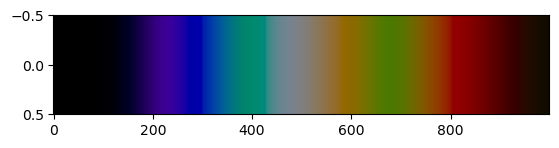

In [15]:
def redshift(l, sRgb):
  power_exp = 1
  linear = np.power(sRgb, 2.2)
  spectral = xyzToSpectral.dot(sRgbToXyz).dot(linear)
  A = np.array([
    [x(R*l), x(G*l), x(B*l)],
    [y(R*l), y(G*l), y(B*l)],
    [z(R*l), z(G*l), z(B*l)],
  ])*l**(-power_exp)
  linear_out = xyzToSRgb.dot(A).dot(spectral)
  return np.power(linear_out, 1/2.2)

ls = np.arange(0.5, 1.5, 0.001)
# TODO: tone mapping to handle values outside sRGB
plt.imshow([[redshift(l, np.array([0.5,0.5,0.5])) for l in ls]], aspect=200)


In [9]:
xyz(400)


0.15059909257291965

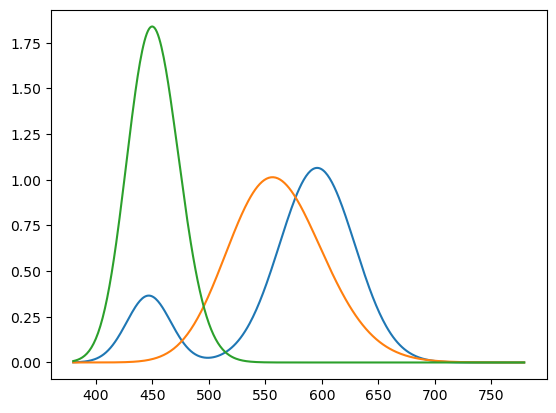

In [10]:
ls = np.arange(380, 780)
plt.plot(ls, x(ls))
plt.plot(ls, y(ls))
plt.plot(ls, z(ls))
